# Setup

In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [5]:
YOUTUBE_VIDEO = "https://www.youtube.com/watch?v=cdiD-9MMpb0"

# First Simple Chain

## LLM Model

In [6]:
from langchain_openai.chat_models import ChatOpenAI

In [9]:
# OPENAI_API_KEY is automatically sourced
model = ChatOpenAI(model="gpt-3.5-turbo")

In [10]:
# Example of query
model.invoke("What MLB team won the World Series during the COVID-19 pandemic?")

AIMessage(content='The Los Angeles Dodgers won the World Series during the COVID-19 pandemic in 2020. They defeated the Tampa Bay Rays in a six-game series to claim their first championship since 1988.', response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 21, 'total_tokens': 61}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-d052d652-eb58-4ec1-8105-d362f9d4baa6-0', usage_metadata={'input_tokens': 21, 'output_tokens': 40, 'total_tokens': 61})

## Output Parser

The result from the model is an `AIMessage` instance containing the answer. We can extract this answer by chaining the model with an [**output parser**](https://python.langchain.com/docs/modules/model_io/output_parsers/).

Here is what chaining the model with an output parser looks like:
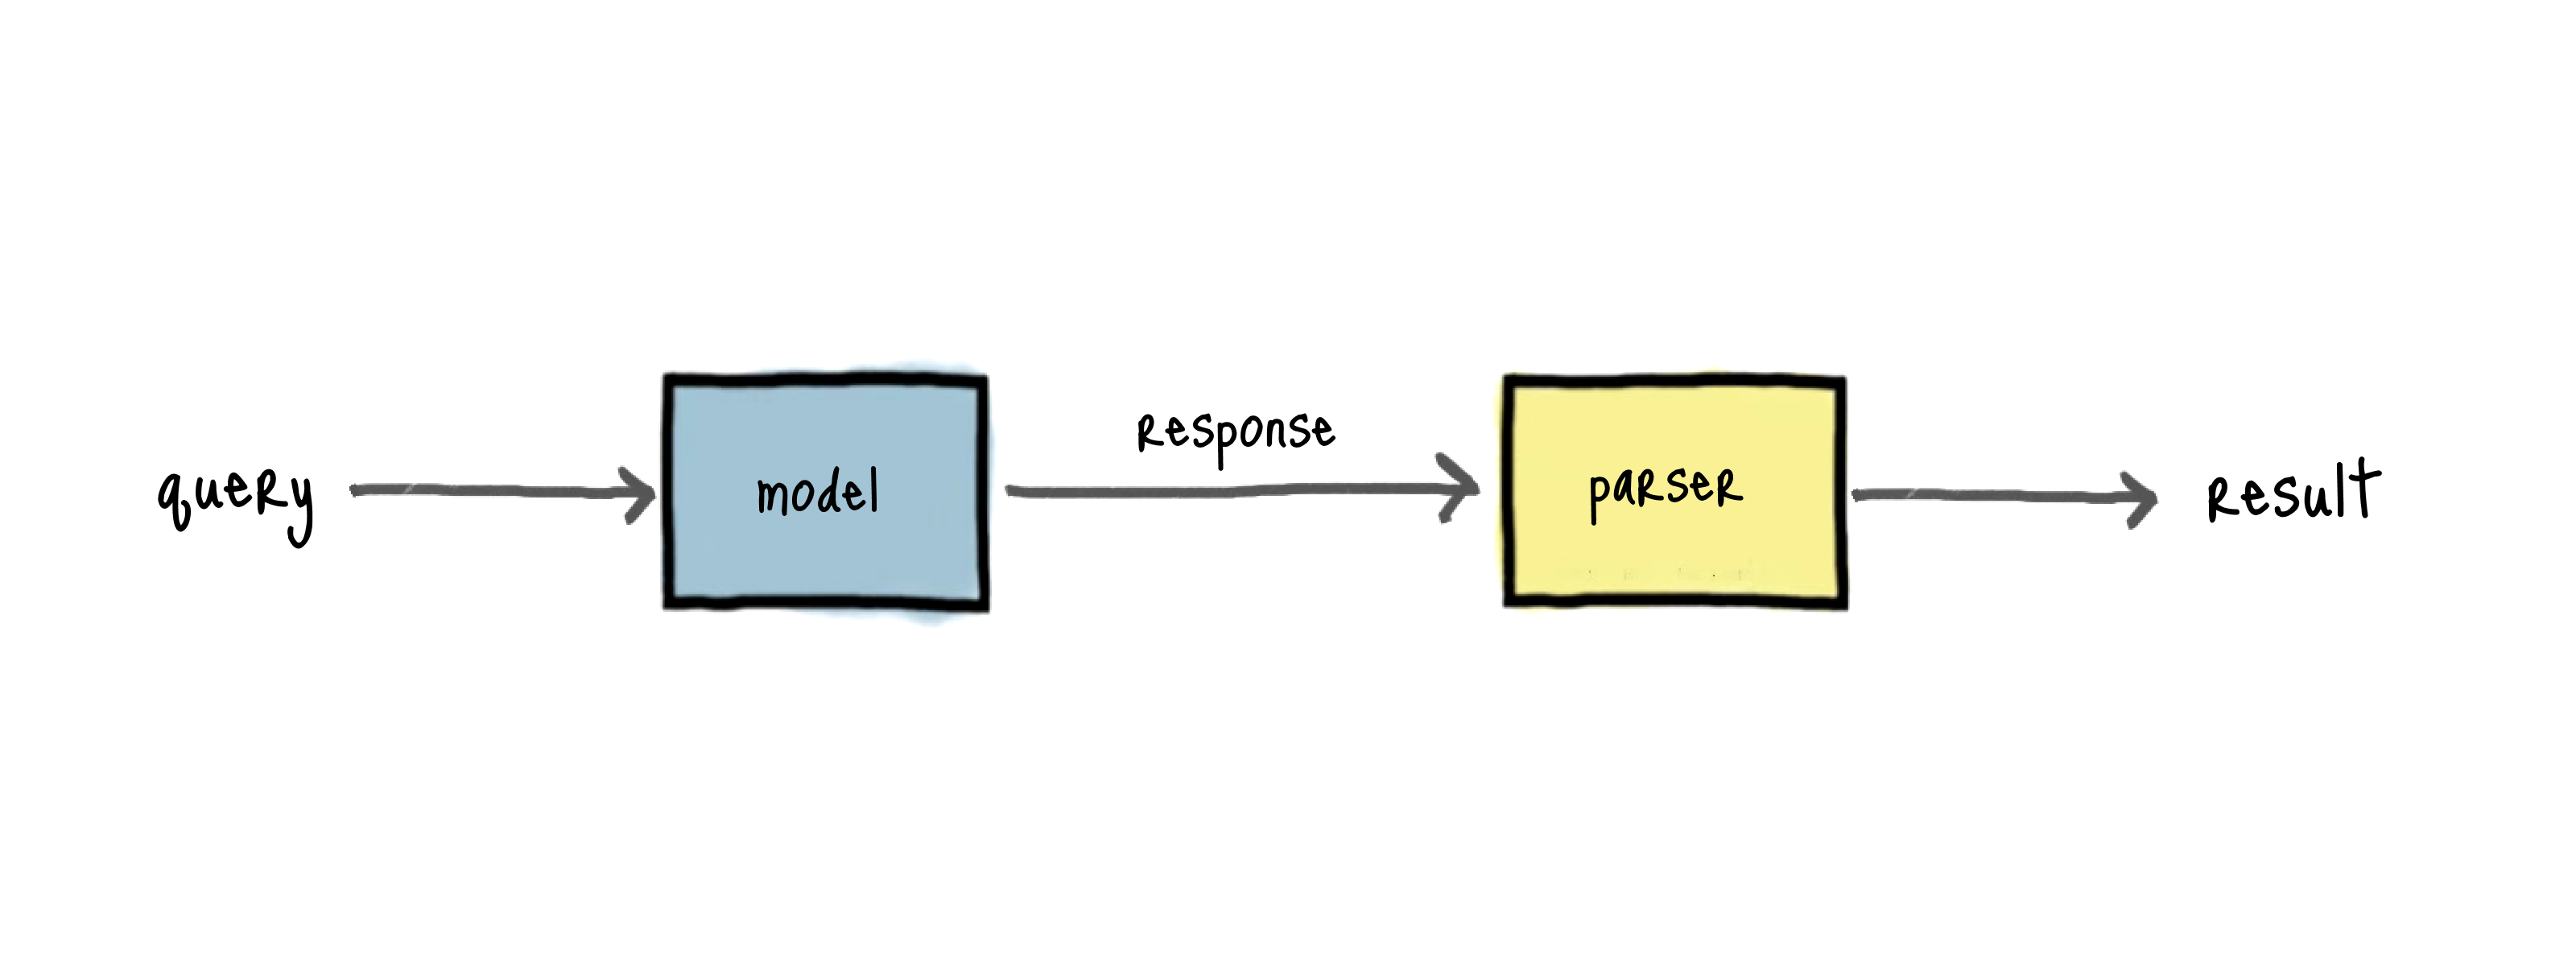

For this example, we'll use a simple `StrOutputParser` to extract the answer as a string.

In [19]:
from langchain_core.output_parsers import StrOutputParser

In [20]:
parser = StrOutputParser()

chain = model | parser

In [21]:
chain

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x784fcd0189a0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x784fccf19330>, openai_api_key=SecretStr('**********'), openai_proxy='')
| StrOutputParser()

In [22]:
chain.invoke("What MLB team won the World Series during the COVID-19 pandemic?")

'The Los Angeles Dodgers won the World Series during the COVID-19 pandemic, defeating the Tampa Bay Rays in six games in October 2020.'

## Chat Prompt Template

In [11]:
from langchain.prompts import ChatPromptTemplate

In [14]:
template = """
Answer the question based on the context below. If you can't \
answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

In [16]:
print(template)


Answer the question based on the context below. If you can't answer the question, reply "I don't know".

Context: {context}

Question: {question}



In [17]:
prompt = ChatPromptTemplate.from_template(template)
prompt.format(context="Mary's sister is Susana.", question="Who is Mary's sister?")

'Human: \nAnswer the question based on the context below. If you can\'t answer the question, reply "I don\'t know".\n\nContext: Mary\'s sister is Susana.\n\nQuestion: Who is Mary\'s sister?\n'

We can now chain the prompt with the model and the output parser.
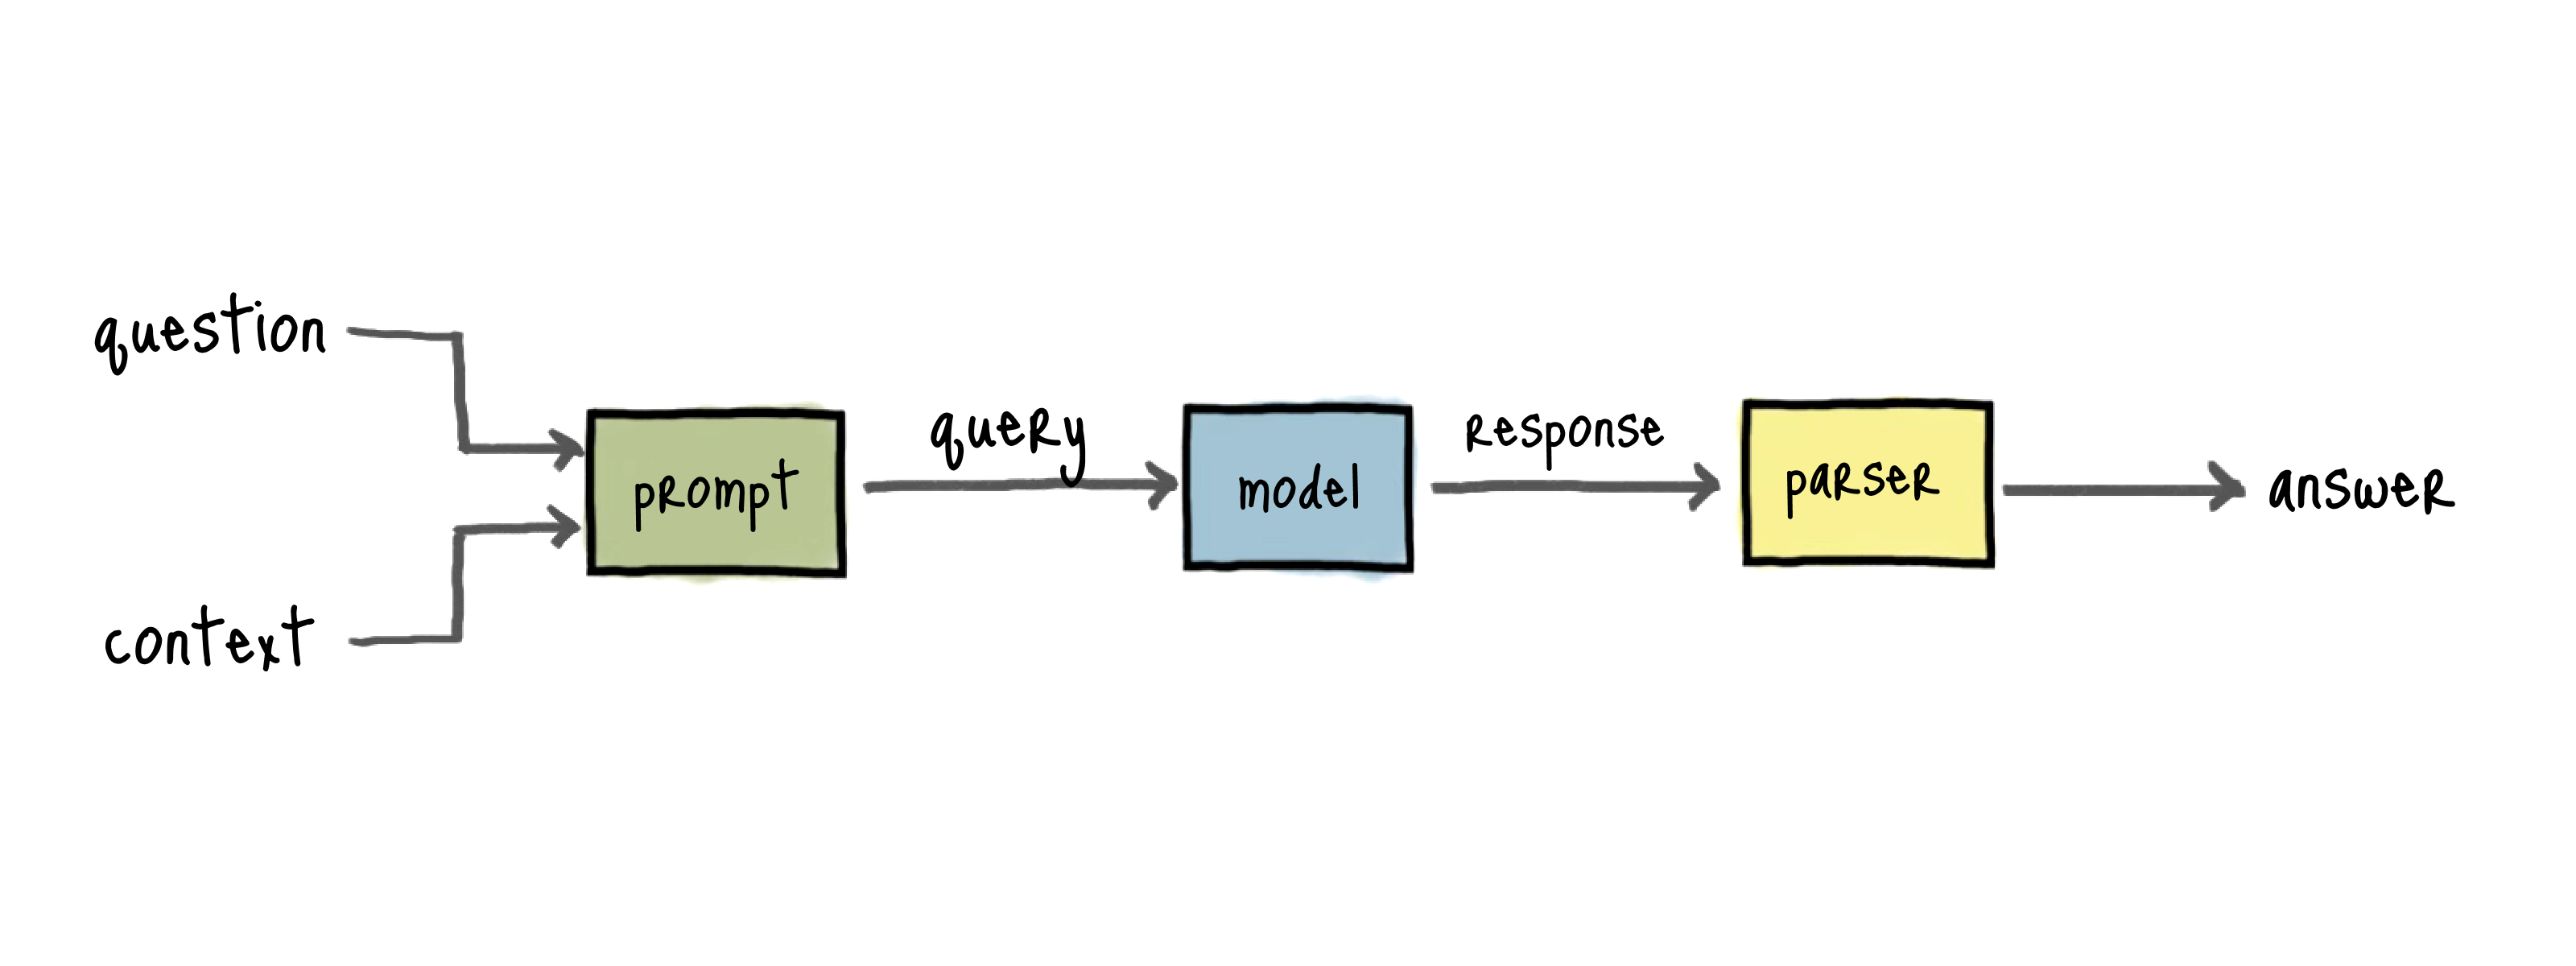

In [23]:
chain = prompt | model | parser

In [24]:
chain

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='\nAnswer the question based on the context below. If you can\'t answer the question, reply "I don\'t know".\n\nContext: {context}\n\nQuestion: {question}\n'))])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x784fcd0189a0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x784fccf19330>, openai_api_key=SecretStr('**********'), openai_proxy='')
| StrOutputParser()

In [25]:
chain.invoke({
    "context": "Mary's sister is Susana",
    "question": "Who is Mary's sister?"
})

'Susana'

# Combining Chains

We can **combine different chains to create more complex workflows**. 

For example, let's create a second chain that translates the answer from the first chain into a different language.

In [26]:
translation_prompt = ChatPromptTemplate.from_template(
    "Translate {answer} to {language}"
)

We can now create a new translation chain that combines:
- the result from the first chain,
- the translation prompt

Here's what the new workflow looks like:
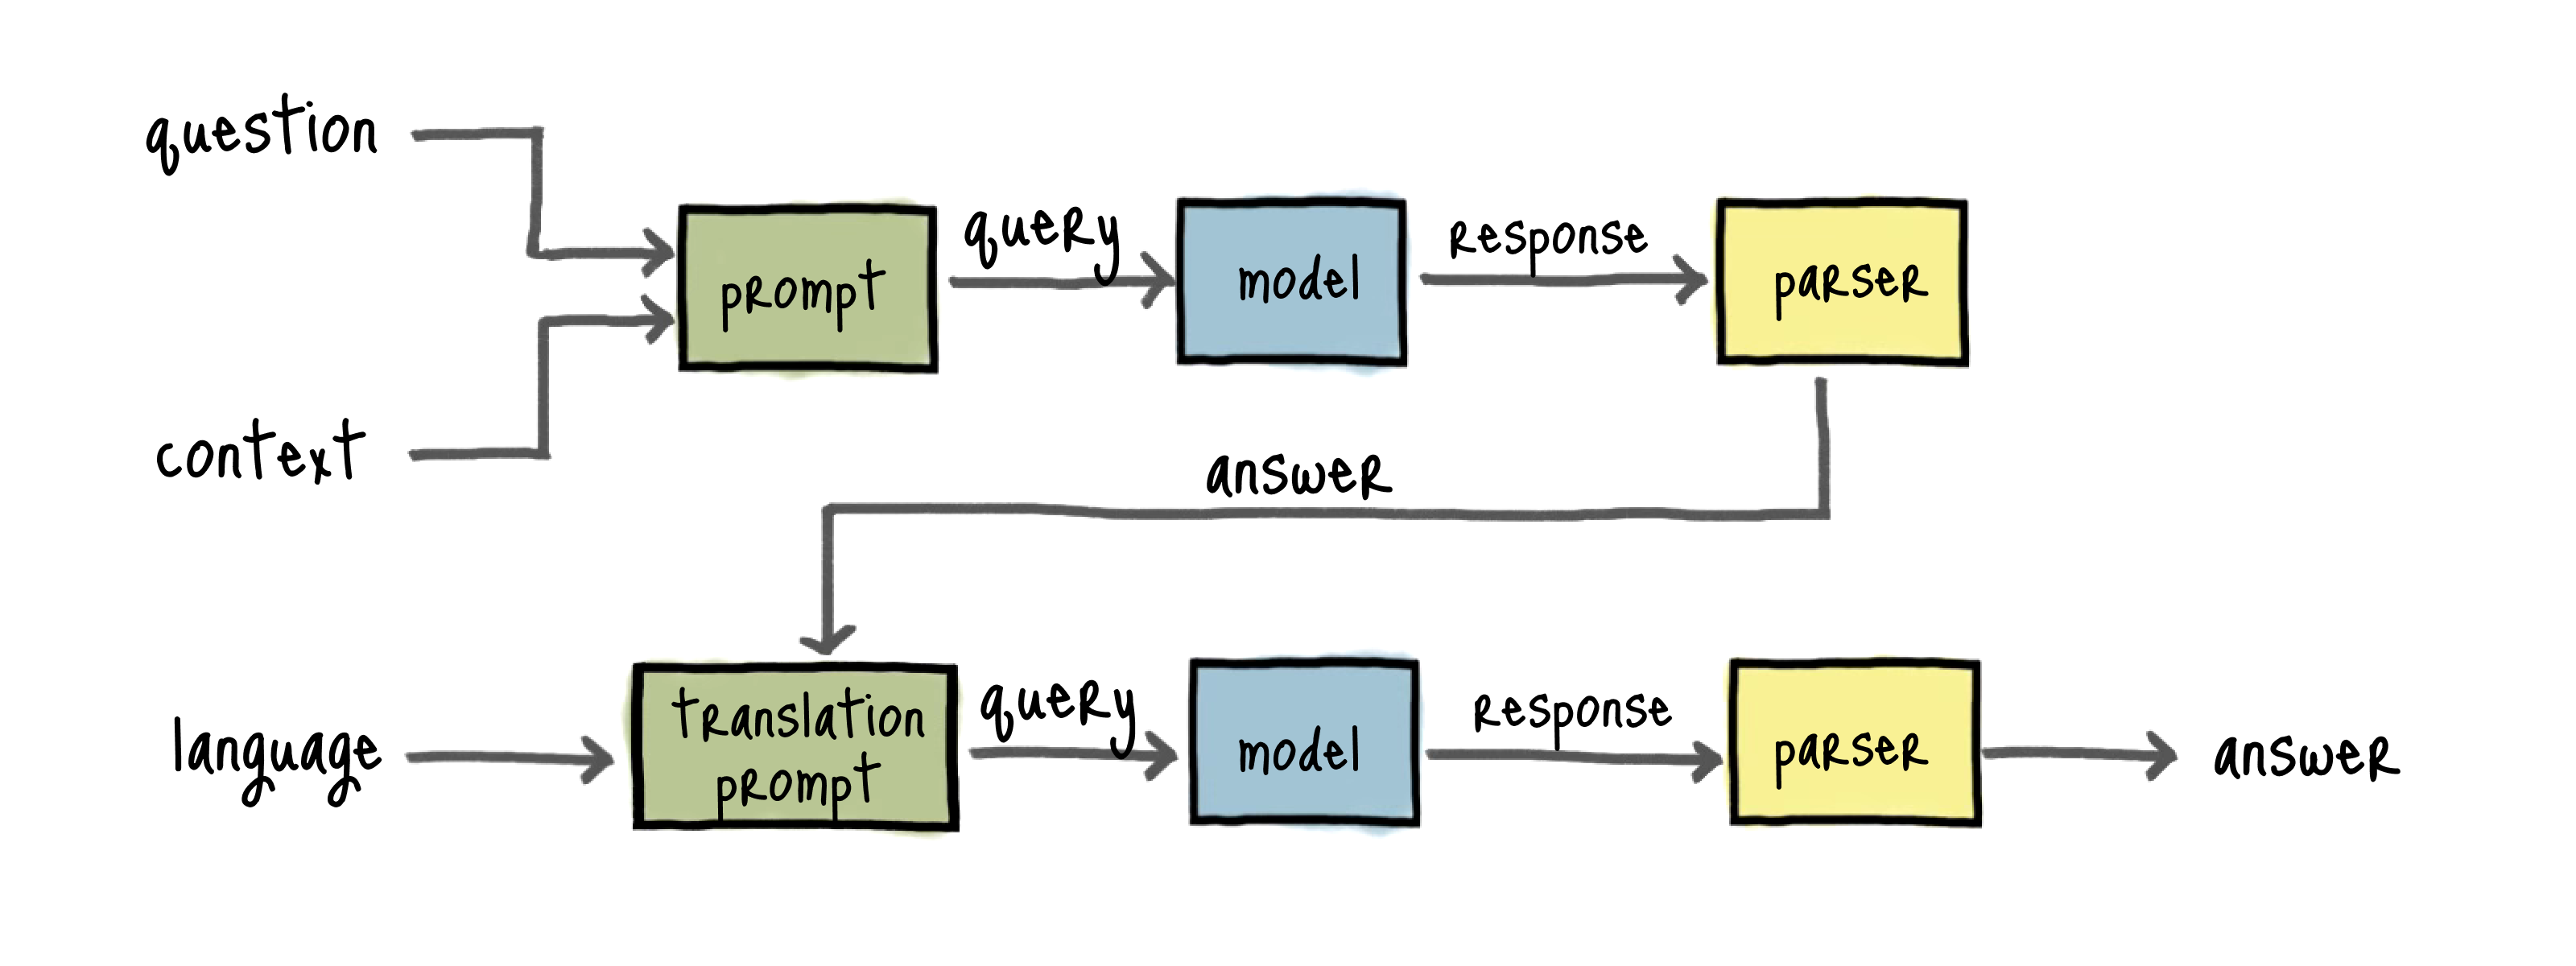
This graph will help us build the full chain.

In [27]:
from operator import itemgetter

In [28]:
translation_chain = (
    {"answer": chain, "language": itemgetter("language")}
    | translation_prompt
    | model
    | parser
)

In [29]:
translation_chain

{
  answer: ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='\nAnswer the question based on the context below. If you can\'t answer the question, reply "I don\'t know".\n\nContext: {context}\n\nQuestion: {question}\n'))])
          | ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x784fcd0189a0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x784fccf19330>, openai_api_key=SecretStr('**********'), openai_proxy='')
          | StrOutputParser(),
  language: RunnableLambda(itemgetter('language'))
}
| ChatPromptTemplate(input_variables=['answer', 'language'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['answer', 'language'], template='Translate {answer} to {language}'))])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x784fcd0189a0>, async_client=<open

The rather weird `itemgetter` syntax above is only here to specify how to manage inputs within the `invoke` method, letting know that the value for `"language"` is gotten from the `dict` input.

In [30]:
translation_chain.invoke(
    {
        "context": "Mary's sister is Susana. She doesn't have any more siblings.",
        "question": "How many sisters does Mary have?",
        "language": "German",
    }
)

'Mary hat eine Schwester, Susana.'

# Transcribing the YouTube Video

The context we want to send the model comes from a YouTube video.

Let's download the video and transcribe it using [**OpenAI's whisper**](https://openai.com/research/whisper)

In [35]:
import os
import tempfile

from openai import OpenAI
import whisper
from pytube import YouTube

In [37]:
client = OpenAI()

In [44]:
# Eventually, translate it to pathlib.Path
if not os.path.exists("transcription.txt"):
    youtube = YouTube(YOUTUBE_VIDEO)
    audio = youtube.streams.filter(only_audio=True).first()

    with tempfile.TemporaryDirectory() as tmpdir:
        audio_file = audio.download(output_path=tmpdir)
        with open(audio_file, "rb") as read_file:
            transcription = client.audio.transcriptions.create(
                model = "whisper-1",
                file = read_file
            )["text"].strip()

        with open("transcription.txt", "w") as write_file:
            write_file.write(transcription)



APIStatusError: Error code: 413 - {'error': {'message': 'Maximum content size limit (26214400) exceeded (26417166 bytes read)', 'type': 'server_error', 'param': None, 'code': None}}

In [45]:
from langchain_community.document_loaders import YoutubeLoader

In [63]:
# Eventually, translate it to pathlib.Path
if not os.path.exists("transcription.txt"):
    with tempfile.TemporaryDirectory() as tmpdir:
        transcript_loader = YoutubeLoader(video_id="cdiD-9MMpb0")
        transcription = transcript_loader.load()[0].page_content
        # Checking documents' length
        print(len(transcript))

        with open("transcription.txt", "w") as write_file:
            write_file.write(transcription)